# Maestría en Inteligencia Artificial Aplicada

# TC 4033: Visión computacional para imágenes y video

# Tecnológico de Monterrey

## Dr. Gilberto Ochoa Ruiz

# **# Métodos de Segmentación: Mean Shift**

## **Equipo # 16**
### Edwin David Hernández Alejandre A01794692
### Miguel Guillermo Galindo Orozco A01793695
### Jorge Pedroza Rivera A01319553
### Juan Carlos Alvarado Carricarte A01793486
### Gerardo Aaron Castañeda Jaramillo A01137646

## Table of Contents
1. [Librerías](#librerías)
2. [Teoría](#teoría)
3. [Ejmplo para segmentación de imagenes](#segmentation)
4. [Automatización con paquetería pymeanshift](#pymeanshift)
5. [Ejemplos imágenes](#Imagenes)
6. [Conclusiones](#Conclusiones)
6. [Referencias](#Referencias)


## Librerías a utilizar <a class="anchor" id="librerías" ></a>

In [27]:
import cv2

import pymeanshift as pms
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cv2 as cv

from sklearn.cluster import MeanShift, estimate_bandwidth



## Teoría de Clustering por Mean Shift <a class="anchor" id="teoría" ></a>

Clustering es una técnica de Machine Learning que implica la agrupación de puntos de datos. Dado un conjunto de puntos de datos, podemos utilizar un algoritmo de agrupación para clasificar cada punto de datos en un clúster específico. En teoría, los puntos de datos que están en el mismo clúster deben tener propiedades y/o características similares, mientras que los puntos de datos en diferentes clústeres deben tener propiedades y/o características muy diferentes. La agrupación es un método de Aprendizaje no Supervisado y es una técnica común para el análisis de datos estadísticos utilizada en muchos campos.

La agrupación Mean Shift es un algoritmo basado en ventanas deslizantes que intenta encontrar áreas densas de puntos de datos. Es un algoritmo basado en el centroide, lo que significa que el objetivo es localizar los puntos centrales de cada clúster, lo que funciona actualizando a los candidatos para que los puntos centrales sean la media de los puntos dentro de la ventana deslizante.

Estas ventanas candidatas son filtradas en una etapa de post procesamiento para eliminar los duplicados cercanos, formando el conjunto final de puntos centrales y sus correspondientes grupos.

Tomando como ejemplo un conjunto de datos creado como el siguiente:

In [12]:
cordinates = [[2, 2, 3], [6, 7, 8], [5, 10, 13]]

X, _ = make_blobs(n_samples = 120, centers = cordinates, cluster_std = 0.60)

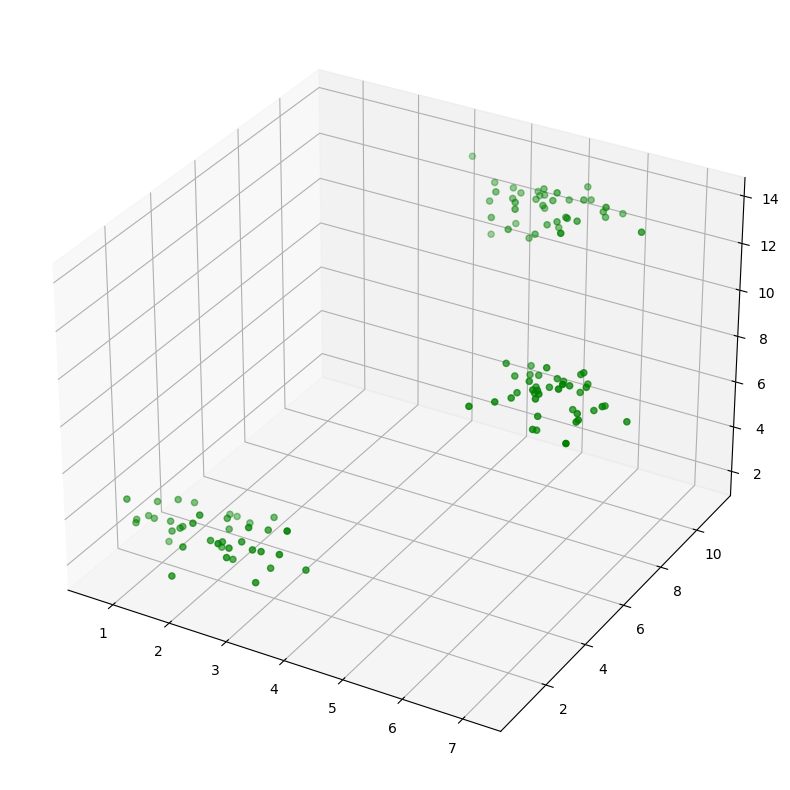

In [13]:
data_fig = plt.figure(figsize=(12, 10))
ax = data_fig.add_subplot(111, projection ='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker ='o',color ='green')
plt.show()

El algorítmo de Mean Shift puede explicarse de la siguiente manera:

1. Inicia con una ventana circular deslizante centrada en el punto C, seleccionada aleatoriamente, y con el radio r como núcleo. Mean Shift es un algoritmo de escalada de colinas que implica el desplazamiento iterativo de este núcleo a una región de mayor densidad en cada paso hasta la convergencia.

2. En cada iteración, la ventana deslizante se desplaza hacia regiones de mayor densidad desplazando el punto central a la media de los puntos dentro de la ventana. La densidad dentro de la ventana deslizante es proporcional al número de puntos dentro de ella. Naturalmente, al cambiar a la media de los puntos en la ventana, gradualmente se moverá hacia áreas de mayor densidad de puntos.

3. Seguimos desplazando la ventana deslizante de acuerdo con la media hasta que no hay dirección en la que un desplazamiento pueda acomodar más puntos dentro del núcleo.

4. Se repite el proceso de los pasos 1 al 3 hasta que todos los puntos se encuentran dentro de una ventana. Cuando se superponen varias ventanas, se conserva la ventana que contiene la mayor cantidad de puntos. A continuación, los puntos de datos se agrupan según la ventana deslizante en la que residen.

Aplicando el método de Mean Shift para crear grupos, se observaría de la siguiente manera:

In [14]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

In [15]:
msc = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msc.fit(X)
cluster_centers = msc.cluster_centers_
labels = msc.labels_
cluster_label = np.unique(labels)


n_clusters = len(cluster_label)
n_clusters

3

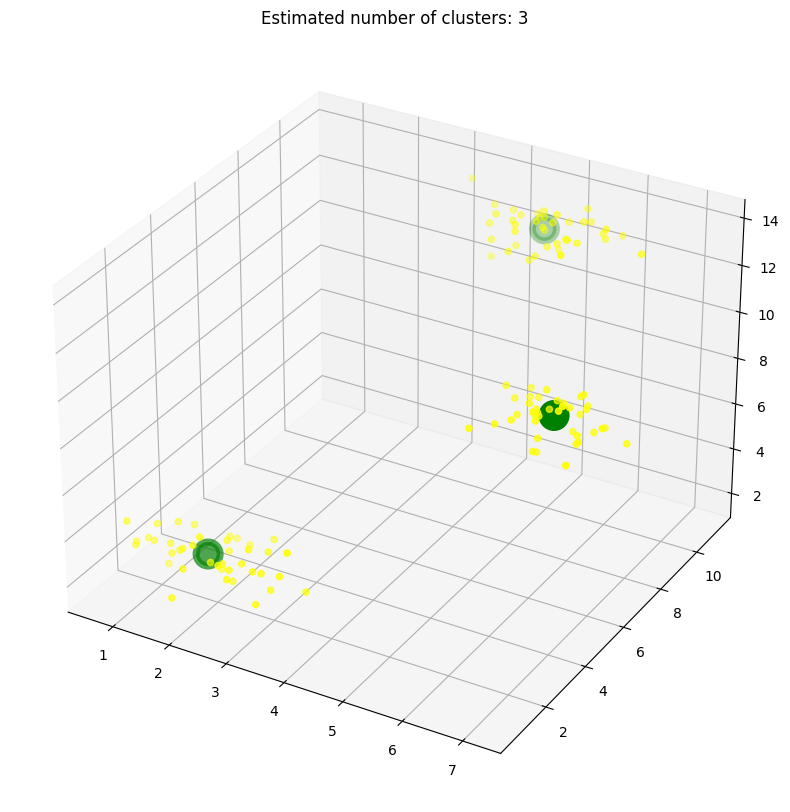

In [16]:
msc_fig = plt.figure(figsize=(12, 10))

ax = msc_fig.add_subplot(111, projection ='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker ='o',color ='yellow')

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           cluster_centers[:, 2], marker ='o', color ='green',
          s = 300, linewidth = 5, zorder = 10)
plt.title('Estimated number of clusters: %d' % n_clusters)
plt.show()

A diferencia de la agrupación K Means, no es necesario seleccionar el número de clústeres, ya que el desplazamiento medio lo descubre automáticamente. Es una gran ventaja. El hecho de que los clustering converjan hacia los puntos de máxima densidad también es muy deseable, ya que es bastante intuitivo de entender y encaja bien en un sentido naturalmente basado en datos. El inconveniente es que la selección del tamaño/radio “r” de la ventana puede ser no trivial.

## Aplicación para segmentación de imagenes <a class="anchor" id="teoría" ></a>

El algorítmo de mean shift puede ser utilizado para segmentar imagenes, realizando un proceso de creación de clusters, y juntando las características (color) de los pixeles que pertenecen a cada grupo

In [17]:
img = cv.imread('/content/image_6.jpg')


Realizamos un tratamiento de la imágen, como reducción de ruido y suavización.

In [18]:
# filter to reduce noise
img = cv.medianBlur(img, 3)

# flatten the image
flat_image = img.reshape((-1,3))
flat_image = np.float32(flat_image)


Se calcula el tamaño de la ventana

In [19]:
# meanshift
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)

Se aplica el algorítmo de mean shift

In [20]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

ms.fit(flat_image)
labeled=ms.labels_


El Algoritmo de Mean Shift encontró los siguientes clusters:

In [21]:
# get number of segments
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])


Number of segments:  4


Con el número de clusters anteriores, la segmentación sería agregar las características de los pixeles dentro de cada uno de los grupos formados, en este caso tomando el promedio del color en cada uno de los grupos y asignando a cada valor del pixel del que forme parte el grupo.

In [22]:
# obtener el promedio del color de cada segmento
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)


In [23]:
# convertir cada pixel al color del segmento
res = avg[labeled]
result = res.reshape((img.shape))

El resultado se observa de la siguiente manera:

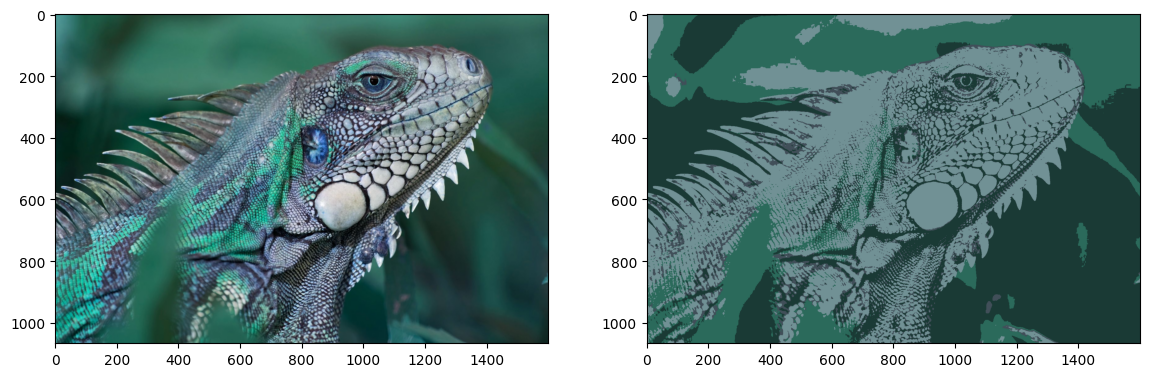

In [24]:
fig = plt.figure(2, figsize=(14, 12))
ax = fig.add_subplot(121)
ax = plt.imshow(img)
ax = fig.add_subplot(122)
ax = plt.imshow(result)
plt.show()


## Implementación por Pymeanshift <a class="anchor" id="teoría" ></a>

Existe una paquetería llamada Pymeanshift que automatiza el proceso de generación de clusters y agregación de las características de los pixeles que conforman cada cluster.

Siguiendo la lógica del algoritmo utiliza el radio de la ventana para el grupo de pixeles de los cuáles se va a calcular la media, considerando además l número de pixeles mínimo que deben considerarse dentro de la ventana deslizane. Cada que se calcule la media, el algoritmo se coloca ahora sobre la nueva media calculada, y con la ventana seleccionada vuelve a calcular la nueva media de dónde se encuentre.  

El proceso continua hasta que la media no sufre un cambio.

Finalmente, una vez formados los grupos, genera un agrupamiento de las características de los pixeles que forman cada grupo. En este caso agrega los colores para que todos los pixeles de cada grupo tengan la misma información de color.

Pymean shift utiliza:

- image -- La imagen de entrada a tratar
- spatial_radius -- Tamaño del radio de la ventana deslizante (integer).
- range_radius -- Rango del radio de la ventana deslizante (integer).
- min_density -- Mínima densidad a alcanzar para continuar con el algoritmo (integer).    

In [28]:
original_image = cv2.imread("/content/image_6.jpg")

(segmented_image, labels_image, number_regions) = pms.segment(original_image, spatial_radius=6,
                                                              range_radius=4.5, min_density=50)

In [29]:
number_regions

5936

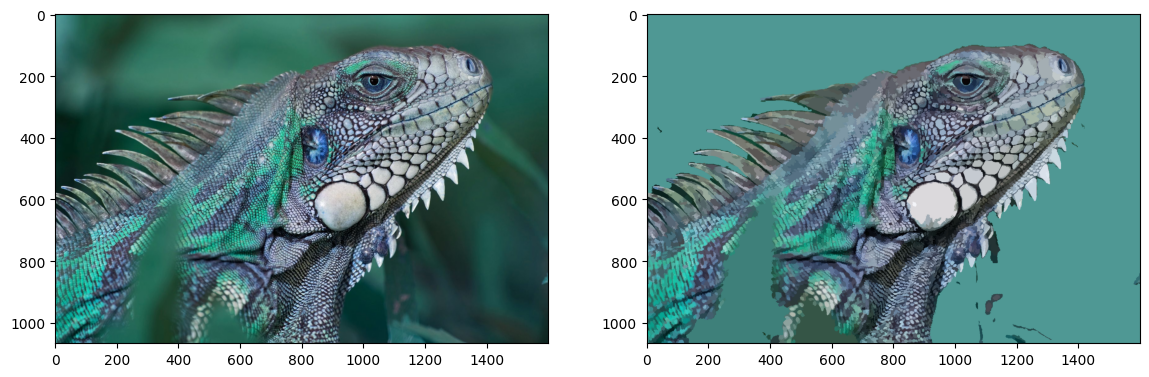

In [30]:
fig = plt.figure(2, figsize=(14, 12))
ax = fig.add_subplot(121)
ax = plt.imshow(original_image)
ax = fig.add_subplot(122)
ax = plt.imshow(segmented_image)
plt.show()


## Ejemplos de imagenes <a class="anchor" id="teoría" ></a>

Ejemplo de aplicación de pymeanshift con diferentes imagenes

In [31]:
original_image = cv2.imread("/content/image_2.jpg")

(segmented_image, labels_image, number_regions) = pms.segment(original_image, spatial_radius=6,
                                                              range_radius=4.5, min_density=50)

number_regions

1717

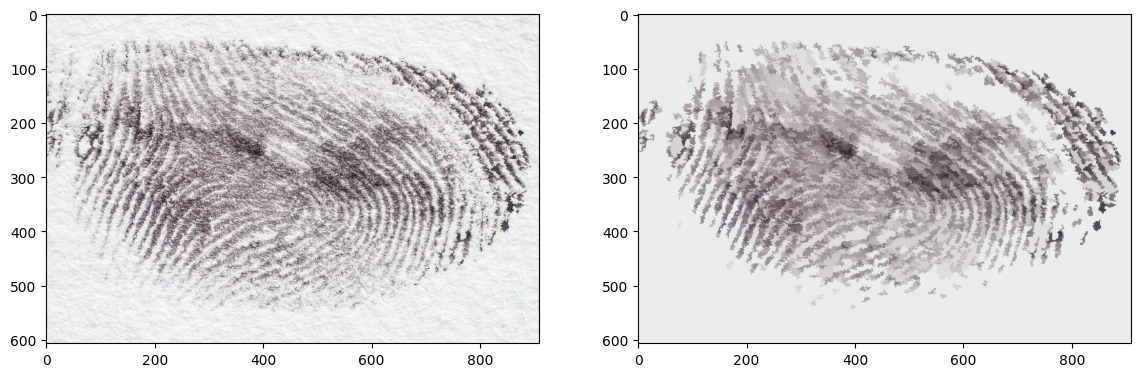

In [32]:
fig = plt.figure(2, figsize=(14, 12))
ax = fig.add_subplot(121)
ax = plt.imshow(original_image)
ax = fig.add_subplot(122)
ax = plt.imshow(segmented_image)
plt.show()


In [33]:
original_image = cv2.imread("/content/image_3.jpg")

(segmented_image, labels_image, number_regions) = pms.segment(original_image, spatial_radius=6,
                                                              range_radius=4.5, min_density=50)

number_regions

44

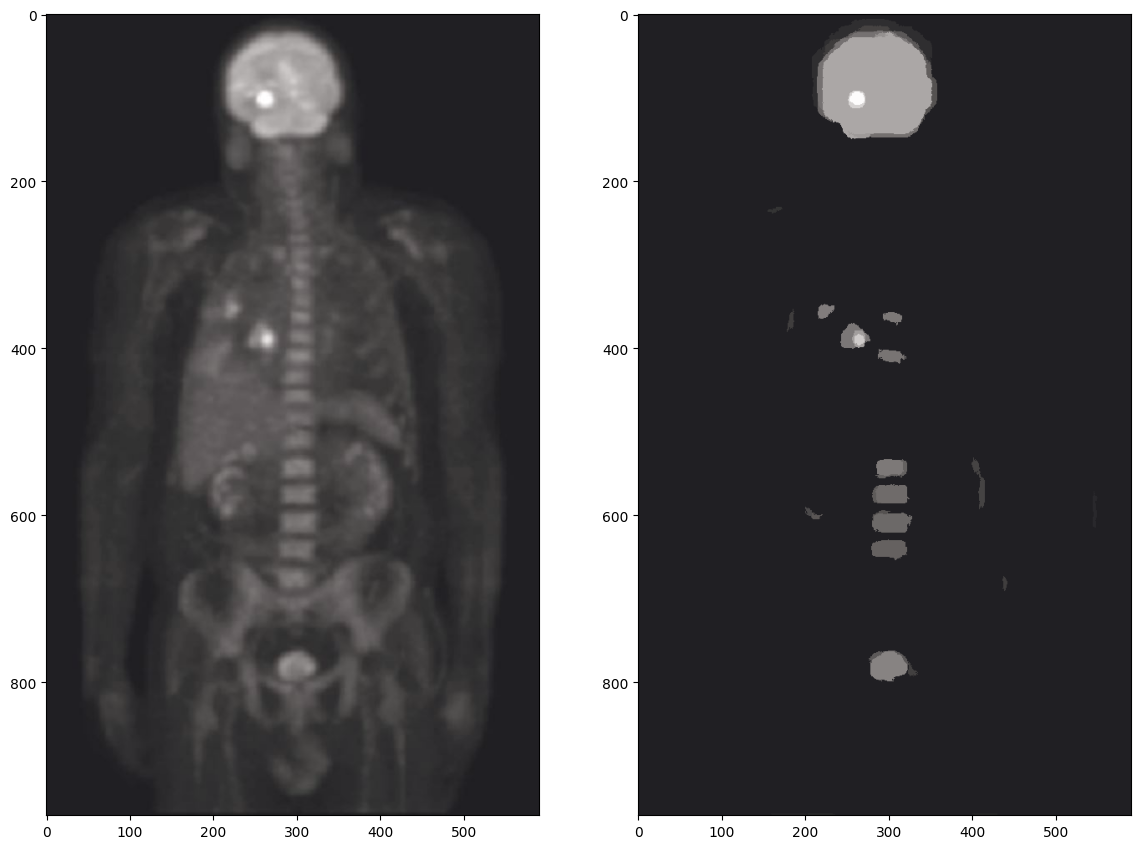

In [34]:
fig = plt.figure(2, figsize=(14, 12))
ax = fig.add_subplot(121)
ax = plt.imshow(original_image)
ax = fig.add_subplot(122)
ax = plt.imshow(segmented_image)
plt.show()


In [35]:
original_image = cv2.imread("/content/image_4.jpg")

(segmented_image, labels_image, number_regions) = pms.segment(original_image, spatial_radius=6,
                                                              range_radius=4.5, min_density=50)

number_regions

623

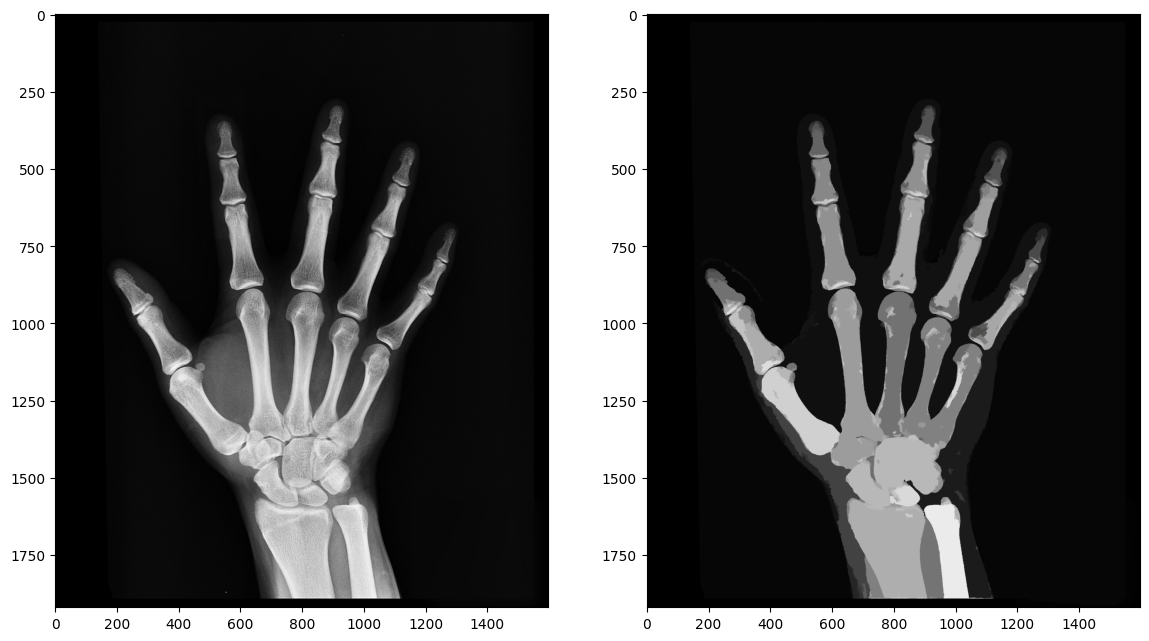

In [36]:
fig = plt.figure(2, figsize=(14, 12))
ax = fig.add_subplot(121)
ax = plt.imshow(original_image)
ax = fig.add_subplot(122)
ax = plt.imshow(segmented_image)
plt.show()


In [39]:
original_image = cv2.imread("/content/image_5.jpg")

(segmented_image, labels_image, number_regions) = pms.segment(original_image, spatial_radius=6,
                                                              range_radius=4.5, min_density=50)

number_regions

1631

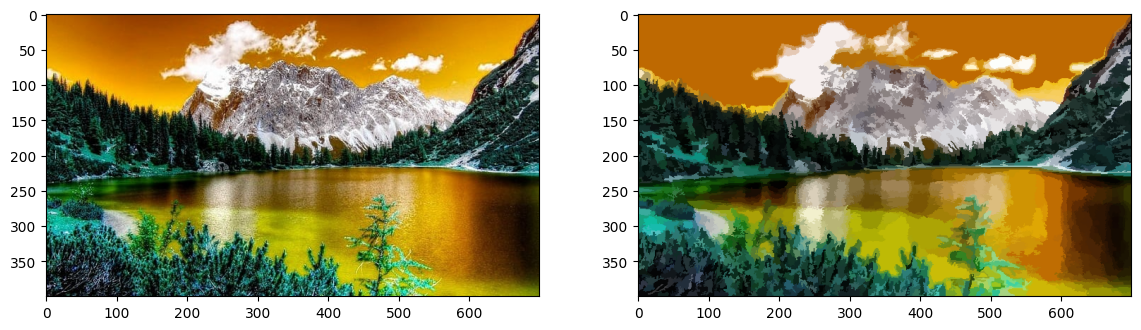

In [40]:
fig = plt.figure(2, figsize=(14, 12))
ax = fig.add_subplot(121)
ax = plt.imshow(original_image)
ax = fig.add_subplot(122)
ax = plt.imshow(segmented_image)
plt.show()


## Conclusiones <a class="anchor" id="teoría" ></a>

## Referencias <a class="anchor" id="teoría" ></a>

* Yugesh Verma. (2024). Hands-On Tutorial on Mean Shift Clustering Algorithm. Retrieved from https://analyticsindiamag.com/hands-on-tutorial-on-mean-shift-clustering-algorithm/
* Geeks For Geeks. (2023). Mean Shift Clustering using Sklearn. Retrieved from Geeks For Geeks: https://www.geeksforgeeks.org/mean-shift-clustering-using-sklearn
* Github - Frederic Jean (2012). Python Module for Mean Shift Image Segmentation. Retrieved from Git: https://github.com/fjean/pymeanshift





